In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
# Given parameters
L = 3.34e5  # Latent heat of phase change (KJ/m^3)
C_i = 1.672  # Heat capacity of ice (KJ/(m^3·K))
C_l = 4.18  # Heat capacity of water (KJ/(m^3·K))
lambda_i = 2.210  # Thermal conductivity of ice (W/(m·K))
lambda_l = 0.465  # Thermal conductivity of water (W/(m·K))

# Unknown parameters
lambda_f = 1.5  # Thermal conductivity of soil matrix (W/(m·K))
C_f = 1.5  # Heat capacity of soil matrix (KJ/(m^3·K))
eta = 0.4  # Porosity of the soil
b = 1.5  # Coefficient for unfrozen water content
T_nabla = -1 # Freezing temperature of the soil (°C)

# Discretization parameters
Nx = 50  # Number of spatial points
Nt = 100000  # Number of time steps
Lx = 5.0  # Length of the domain (m) (from 0 m to 5.0 m)
T_total = 365.0  # Total time (days)
# T_total = 180.0  # Total time (days)
dx = Lx / (Nx - 1)  # Spatial step size
dt = T_total / Nt  # Time step size

# Define functions
def pore_water_content(T, T_nabla, b):
    """Calculate pore water content."""
    return np.where(T >= T_nabla, 1, np.abs(T_nabla)**b * np.abs(T)**(-b))

def unfrozen_water_content(T, T_nabla, b, eta):
    """Calculate unfrozen water content."""
    phi = pore_water_content(T, T_nabla, b)
    return eta * phi

def effective_concentration(C_f, C_l, C_i, eta, phi):
    """Calculate effective heat capacity."""
    C_t_value = C_f + eta * (C_l - C_i)
    return phi * C_t_value + (1 - phi) * C_f

def effective_lambda(lambda_f, lambda_l, lambda_i, eta, phi):
    """Calculate effective thermal conductivity."""
    lambda_t_value = lambda_f * (lambda_l / lambda_i) ** eta
    return lambda_t_value ** phi * lambda_f ** (1 - phi)

# Boundary condition function
def temperature(t):
    """Boundary temperature function at x=0."""
    return 4.03 + 16.11 * np.sin((2 * np.pi * t / 365) - 1.709)  # Temperature in °C

# Linear interpolation function
def linear_interpolation(z, z1, z2, T1, T2):
    """
    Linear interpolation to calculate temperature at depth z.
    """
    if z1 == z2:
        raise ValueError("z1 and z2 cannot be the same.")
    return T1 + (T2 - T1) / (z2 - z1) * (z - z1)

# Initialize temperature profile using linear interpolation
def initialize_temperature_profile(depths, z1, z2, T1, T2):
    """
    Initialize temperature profile using linear interpolation.
    """
    temperatures = np.zeros_like(depths)
    for i, z in enumerate(depths):
        temperatures[i] = linear_interpolation(z, z1, z2, T1, T2)
    return temperatures

# Define spatial grid
x = np.linspace(0, Lx, Nx)  # Spatial grid from 0 m to 5.0 m

# Define boundary conditions for interpolation
z1, T1 = 0.0, temperature(0)  # Upper boundary condition at x=0 m
z2, T2 = Lx, 1.0  # Lower boundary condition at x=5.0 m (1 °C)

# Initialize temperature profile
T = initialize_temperature_profile(x, z1, z2, T1, T2)

# Initialize the temperature field as a 2D array
T_field = np.zeros((Nx, Nt))  # Temperature field: T(x, t)
T_field[:, 0] = T  # Set initial condition

# Time-stepping loop
for n in range(Nt):
    t_n = n * dt
    
    # Apply Dirichlet boundary conditions
    T[0] = temperature(t_n)  # Upper boundary condition at x=0 m
    T[-1] = 1.0  # Lower boundary condition at x=5.0 m (1 °C)
    
    
    # Compute effective properties
    phi = pore_water_content(T, T_nabla, b)
    theta = unfrozen_water_content(T, T_nabla, b, eta)
    C_eff = effective_concentration(C_f, C_l, C_i, eta, phi)
    lambda_eff = effective_lambda(lambda_f, lambda_l, lambda_i, eta, phi)
    
    # Debugging: Print intermediate values
    if np.any(np.isnan(C_eff)) or np.any(np.isnan(lambda_eff)):
        print(f"Warning: NaN detected at t = {t_n}")
        print("C_eff:", C_eff)
        print("lambda_eff:", lambda_eff)
        break
    
    # Compute the right-hand side of the discretized equation
    rhs = np.zeros(Nx)
    for i in range(1, Nx-1):
        lambda_plus = 0.5 * (lambda_eff[i] + lambda_eff[i+1])
        lambda_minus = 0.5 * (lambda_eff[i] + lambda_eff[i-1])
        rhs[i] = (lambda_plus * (T[i+1] - T[i]) - lambda_minus * (T[i] - T[i-1])) / dx**2
    
    # Update temperature
    T[1:-1] += dt * (rhs[1:-1] - L * (theta[1:-1] - theta[1:-1]) / dt) / C_eff[1:-1]
    
    # Store the temperature field at the current time step
    T_field[:, n] = T


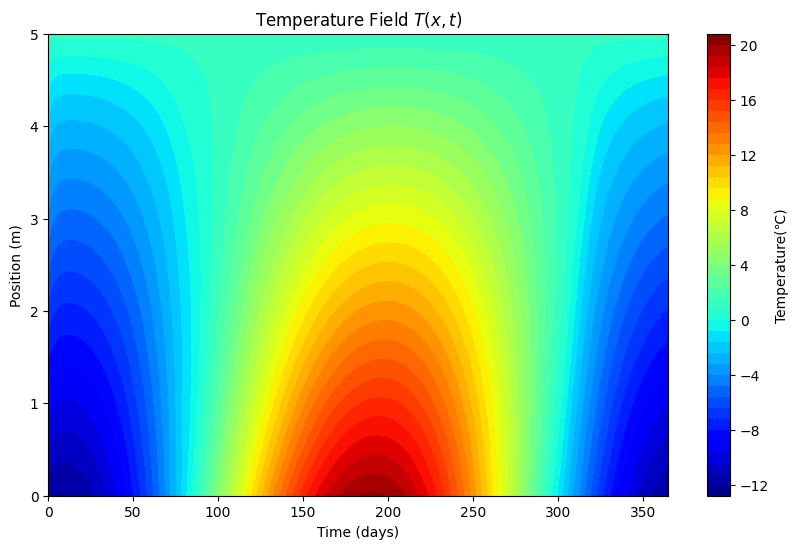

<Figure size 640x480 with 0 Axes>

In [2]:
# Plot the temperature field as a 2D image
plt.figure(figsize=(10, 6))
# analytical solutions
plt.contourf(np.linspace(0, T_total, Nt), x, T_field, levels=50, cmap='jet')
plt.colorbar(label='Temperature(℃)')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('FDM Solution')
plt.xlabel('Time (days)')
plt.ylabel('Position (m)')
plt.title('Temperature Field $T(x, t)$')
plt.show()

# Save the plot as an image
plt.savefig('temperature_field_dirichlet.png', dpi=300, bbox_inches='tight')

In [3]:
T_field_FDM = T_field.shape;

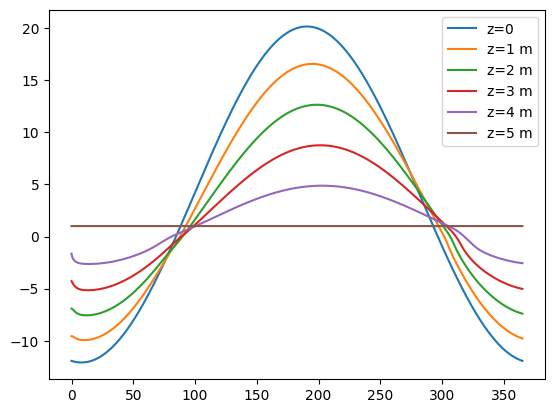

In [4]:
plt.plot(np.linspace(0, T_total, Nt),T_field[0,:],label = 'z=0')
plt.plot(np.linspace(0, T_total, Nt),T_field[9,:],label = 'z=1 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[19,:],label = 'z=2 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[29,:],label = 'z=3 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[39,:],label = 'z=4 m')
plt.plot(np.linspace(0, T_total, Nt),T_field[49,:],label = 'z=5 m')
plt.legend()

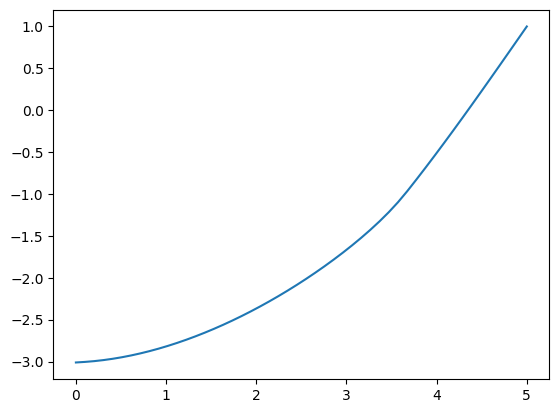

In [5]:
plt.plot(x,T_field[:,20000])

FDM data saved to fdm_observation_data.csv
Number of time points: 100000
Saved depths: [0, 1, 2, 3, 4, 5]m
Data shape: (100000, 7)

Column names:
  - time_days
  - temperature_0m
  - temperature_1m
  - temperature_2m
  - temperature_3m
  - temperature_4m
  - temperature_5m


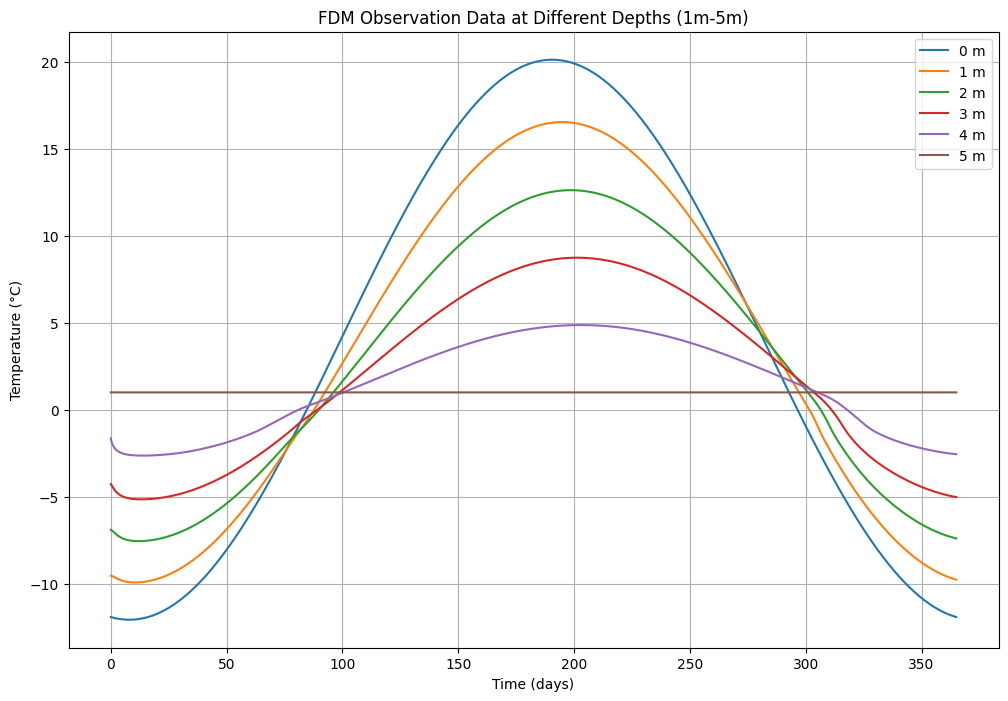


First 5 rows of data:
   time_days  temperature_0m  temperature_1m  temperature_2m  temperature_3m  \
0    0.00000      -11.926392       -9.552234       -6.914287       -4.276604   
1    0.00365      -11.926532       -9.552312       -6.914457       -4.277133   
2    0.00730      -11.926671       -9.552390       -6.914628       -4.277667   
3    0.01095      -11.926810       -9.552468       -6.914799       -4.278204   
4    0.01460      -11.926949       -9.552546       -6.914971       -4.278746   

   temperature_4m  temperature_5m  
0       -1.641872             1.0  
1       -1.645727             1.0  
2       -1.649533             1.0  
3       -1.653264             1.0  
4       -1.656913             1.0  

Statistical summary:
           time_days  temperature_0m  temperature_1m  temperature_2m  \
count  100000.000000   100000.000000   100000.000000   100000.000000   
mean      182.500000        4.030000        3.370696        2.655721   
std       105.368005       11.391547      

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def save_existing_fdm_data_to_csv(T_field, T_total, Nt, filename='fdm_observation_data.csv'):
    """
    Save existing FDM data to CSV format.
    The first column is time, and the following five columns represent the temperature fields
    at depths of 1m, 2m, 3m, 4m, and 5m.
    
    Parameters:
    T_field: temperature field [space_points, time_points] - your existing data
    T_total: total time (days) - your existing data
    Nt: number of time steps - your existing data
    filename: output filename
    """
    
    # Time array
    time_days = np.linspace(0, T_total, Nt)
    
    # Define depth indices and corresponding actual depths (save only 1m–5m)
    depth_indices = [0, 9, 19, 29, 39, 49]  # indices corresponding to 1m–5m depths
    actual_depths = [0, 1, 2, 3, 4, 5]      # actual depth values (meters)
    
    # Create a data dictionary
    data_dict = {'time_days': time_days}
    
    # Add temperature data for each depth (save only 1m–5m)
    for idx, depth_idx in enumerate(depth_indices):
        column_name = f'temperature_{actual_depths[idx]}m'
        data_dict[column_name] = T_field[depth_idx, :]
    
    # Create DataFrame
    df = pd.DataFrame(data_dict)
    
    # Save as CSV
    df.to_csv(filename, index=False)
    
    print(f"FDM data saved to {filename}")
    print(f"Number of time points: {len(time_days)}")
    print(f"Saved depths: {actual_depths}m")
    print(f"Data shape: {df.shape}")
    print("\nColumn names:")
    for col in df.columns:
        print(f"  - {col}")
    
    # Plot the saved data for verification
    plt.figure(figsize=(12, 8))
    for depth in actual_depths:
        plt.plot(df['time_days'], df[f'temperature_{depth}m'], label=f'{depth} m')
    
    plt.xlabel('Time (days)')
    plt.ylabel('Temperature (°C)')
    plt.title('FDM Observation Data at Different Depths (1m-5m)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Show the first few rows of data
    print("\nFirst 5 rows of data:")
    print(df.head())
    
    # Show data statistics
    print("\nStatistical summary:")
    print(df.describe())
    
    return df

# Directly call the function to save data
# Ensure you already have the following variables:
# T_field, T_total, Nt

# Call the saving function
df = save_existing_fdm_data_to_csv(T_field, T_total, Nt, 'fdm_observation_data.csv')
